In [244]:
import pandas as pd
# https://data.binance.vision/?prefix=data/spot/monthly/klines/BTCUSDT/1s/
# src = "https://data.binance.vision/data/spot/monthly/klines/BTCUSDT/1s/"
src = "./data/"

names=["timestamp","open","high","low","close","volume_BTC","close_timestamp","volume_USDT","num_trade","sell_volume_in_BTC","buy_volume_in_USDT", "_"]
usecols=["timestamp","close"]
df = pd.concat([
    pd.read_csv("./data/BTCUSDT-1s-"+date+".zip", header=None, names=names, usecols=usecols)
    for date in pd.date_range(start = "2022-11", end = "2025-11").to_period('M').astype(str).unique()
])

for f in ["timestamp", "close_timestamp"]:
    if f in df.columns:
        df[f] = pd.to_datetime(df[f].apply(lambda x: (x*1000000) if x<1500000000000000 else (x*1000)))
df = df.set_index("timestamp", drop=True).sort_index()

KeyboardInterrupt: 

In [ ]:
df.to_pickle("tmp.pkl")
df = pd.read_pickle("tmp.pkl")
x_d = df["close"].resample("1D").last()
xi_d = x_d.diff()
xi_d = xi_d - xi_d.mean()
xi_sq = np.square(xi_d.values[1:])


In [ ]:
df

,close
timestamp,
2022-11-01 00:00:00,20491.94
2022-11-01 00:00:01,20491.99
2022-11-01 00:00:02,20491.62
2022-11-01 00:00:03,20491.45
2022-11-01 00:00:04,20491.00
...,...
2025-11-30 23:59:55,90377.40
2025-11-30 23:59:56,90360.01
2025-11-30 23:59:57,90360.00


In [ ]:
# x_d = df["close"].resample("1D").last()
# xi_d = x_d.diff()
# xi_d = xi_d - xi_d.mean()
# xi_sq = np.square(xi_d.values[1:])

# import numpy as np

# def vol_est(vol_prev, rv, vol_coef, rv_coef, resid):
#     # volatility at t := expectation of return^2(t) at (t-1)   
#     return vol_coef*vol_prev + rv_coef*rv + resid

# def vol_est_arr(rv_arr, vol_coef, rv_coef, resid):
#     result = np.zeros(len(rv_arr)+1)
#     for i in range(len(result)):
#         result[i] = vol_est(result[i-1], rv_arr[i-1], vol_coef, rv_coef, resid)
#     historical = result[:-1]
#     estimation = result[-1]
#     return historical, estimation

# def likelihood(vol_est_arr, rv_arr):
#     return - np.sum(np.log(vol_est_arr) + rv_arr / vol_est_arr)


In [ ]:
import numpy as np 
import pandas as pd 
import torch

df = pd.read_pickle("tmp.pkl")


def vol_est(vol_prev, rv, vol_coef, rv_coef, resid=0):
    # volatility at t := expectation of return^2(t) at (t-1)   
    return vol_coef*vol_prev + rv_coef*rv + resid

def vol_est_arr(rv_arr, vol_coef, rv_coef, resid, backend=torch, device="cpu"):
    # backend can be torch or np
    result = [torch.Tensor([0]).to(device)]
    for i in range(len(rv_arr)):
        result.append(vol_est(result[i], rv_arr[i], vol_coef, rv_coef, resid))
    historical = backend.concat(result[:-1])
    historical = backend.maximum(historical, torch.tensor(1e-6).to(device)) # for stability
    estimation = result[-1]
    return historical, estimation

def likelihood(vol_est_arr, rv_arr, backend=torch):
    ll1 = backend.log(vol_est_arr) + rv_arr / vol_est_arr
    # prevent divergence in vol < epsilon
    epsilon = 1e-6
    ll2 = (1 / epsilon - rv_arr / epsilon / epsilon) * vol_est_arr + (float(np.log(epsilon)) + 2. * rv_arr / epsilon - 1.)
    ll = backend.where(vol_est_arr>epsilon, ll1, ll2)
    return -backend.sum(ll)

def rv_daily(df, backend=torch, device="cpu"):
    x_d = df["close"].resample("1D").last()
    xi_d = np.log(x_d).diff()
    xi_d = xi_d - xi_d.mean()
    xi_sq = np.square(xi_d.values[1:])
    if backend==torch:
        return torch.Tensor(xi_sq).to(device)
    elif backend==np:
        return xi_sq

def optimize_torch(rv_arr, init_params=(1e-3,1e-3,0.0), iter=1000, device=torch.device("cpu")):
    backend=torch
    vol_coef, rv_coef, resid = [torch.tensor(x, requires_grad=True) for x in init_params]
    # opt = torch.optim.Adam([vol_coef, rv_coef, resid], lr=1e-3)
    opt = torch.optim.Adam([vol_coef, rv_coef], lr=1e-2)
    for epoch in range(iter):
        opt.zero_grad()
        historical_est, next_est = vol_est_arr(rv_arr, vol_coef, rv_coef, resid, backend=backend, device=device) # It looks like a RNN 
        loss = -likelihood(historical_est, rv_arr, backend=backend)
        loss.backward()
        opt.step()
    print(f"[{epoch}] loss:{loss.item():.2e}, params:{vol_coef.item():.2e}, {rv_coef.item():.2e}, {resid.item():.2e}, est:{next_est.item():.2e}")
    params = (vol_coef.item(), rv_coef.item(), resid.item())
    return params, next_est.item(), loss.item()

# print(w.item())


In [110]:
backend = torch
device = torch.device("cpu")
rv_arr_all = rv_daily(df, backend=backend, device=device)

est_rv = dict()
lookback = 250
params = (1e-3,1e-3,0.0)
for i in range(lookback,len(rv_arr_all)):
    rv_arr = rv_arr_all[i-lookback:i]
    params, vol_pred, loss = optimize_torch(rv_arr, init_params=params, device=device, iter=200)
    vol_coef, rv_coef, resid = params
    est_rv[i] = {"vol_coef":vol_coef, "rv_coef":rv_coef, "resid":resid, "vol_pred":vol_pred, "loss":loss}
    if i % 10 == 0:
        print(i)
        pd.DataFrame(est_rv).T.to_csv("result.csv")
        pd.DataFrame(est_rv).T.to_csv("result.pkl")

[199] loss:-9.94e+02, params:7.79e-01, 1.13e-01, 0.00e+00, est:7.29e-05
250
[199] loss:3.63e+02, params:7.68e-01, 3.44e-01, 0.00e+00, est:1.76e-04
[199] loss:3.65e+02, params:7.40e-01, 4.09e-01, 0.00e+00, est:1.40e-04
[199] loss:-1.53e+03, params:5.92e-01, 8.89e-01, 0.00e+00, est:1.51e-04
[199] loss:-1.16e+03, params:6.31e-01, 7.48e-01, 0.00e+00, est:9.28e-04
[199] loss:-1.27e+03, params:5.53e-01, 1.08e+00, 0.00e+00, est:2.31e-03
[199] loss:9.61e+03, params:7.90e-01, 2.94e-01, 0.00e+00, est:6.18e-04
[199] loss:2.21e+04, params:8.57e-01, 1.73e-01, 0.00e+00, est:4.06e-04
[199] loss:8.14e+03, params:9.60e-01, 4.32e-02, 0.00e+00, est:4.13e-04
[199] loss:-6.13e+02, params:8.73e-01, 1.63e-01, 0.00e+00, est:3.48e-04
[199] loss:-1.35e+03, params:8.04e-01, 2.88e-01, 0.00e+00, est:2.94e-04
260
[199] loss:-7.12e+02, params:8.76e-01, 1.59e-01, 0.00e+00, est:2.70e-04
[199] loss:-1.37e+03, params:8.27e-01, 2.43e-01, 0.00e+00, est:2.10e-04
[199] loss:-1.39e+03, params:8.17e-01, 2.62e-01, 0.00e+00, es

In [ ]:
import numpy as np 
import pandas as pd 
import torch
from data import get_data
from util import vol_est_arr, likelihood, rv_naive, rv_preaveraged
df = pd.read_pickle("tmp.pkl")


def optimize_torch(rv_arr, init_params=(1e-3,1e-3,1e-3), iter=1000, device=torch.device("cpu")):
    backend=torch
    omega, beta, gamma = [torch.tensor(x, requires_grad=True) for x in init_params]
    opt = torch.optim.Adam([omega, beta, gamma], lr=1e-2)
    vol_coef = gamma
    rv_coef = (gamma-1)/beta*(torch.exp(beta)-1-beta)+torch.exp(beta)-1
    resid = (torch.exp(beta)-1)*omega/beta
    for epoch in range(iter):
        opt.zero_grad()
        historical_est, next_est = vol_est_arr(rv_arr, vol_coef, rv_coef, resid, backend=backend, device=device) # It looks like a RNN 
        loss = -likelihood(historical_est, rv_arr, backend=backend)
        loss.backward()
        opt.step()
    print(f"[{epoch}] loss:{loss.item():.2e}, params:{vol_coef.item():.2e}, {rv_coef.item():.2e}, {resid.item():.2e}, est:{next_est.item():.2e}")
    params = (vol_coef.item(), rv_coef.item(), resid.item())
    return params, next_est.item(), loss.item()

# print(w.item())


In [ ]:
backend = torch
device = torch.device("cpu")
rv_arr_all = rv_naive(df, backend=backend, device=device)

est_rv = dict()
lookback = 250
params = (1e-3,1e-3,0.0)
for i in range(lookback,len(rv_arr_all)):
    rv_arr = rv_arr_all[i-lookback:i]
    params, vol_pred, loss = optimize_torch(rv_arr, init_params=params, device=device, iter=200)
    vol_coef, rv_coef, resid = params
    est_rv[i] = {"vol_coef":vol_coef, "rv_coef":rv_coef, "resid":resid, "vol_pred":vol_pred, "loss":loss}
    if i % 10 == 0:
        print(i)
        pd.DataFrame(est_rv).T.to_csv("result.csv")
        pd.DataFrame(est_rv).T.to_csv("result.pkl")

,Unnamed: 0,vol_coef,rv_coef,resid,vol_pred,loss
0,250,0.890187,0.127367,0.0,0.000282,-1199.036377
1,251,0.892903,0.120090,0.0,0.000254,393.538391


In [ ]:
import numpy as np 
import pandas as pd 
import torch
from data import get_data
from util import vol_est_arr, likelihood, rv_naive, rv_preaveraged

def get_data():
    df = pd.read_pickle("tmp.pkl")
    return df


def optimize_torch(rv_arr, init_params=(1e-3,1e-3,1e-3), iter=1000, device=torch.device("cpu")):
    backend=torch
    omega, beta, gamma = [torch.tensor(x, requires_grad=True) for x in init_params]
    opt = torch.optim.Adam([omega, beta, gamma], lr=1e-2)
    for epoch in range(iter):
        opt.zero_grad()
        vol_coef = gamma
        rv_coef = (gamma-1)/beta*(torch.exp(beta)-1-beta)+torch.exp(beta)-1
        resid = (torch.exp(beta)-1)*omega/beta
        historical_est, next_est = vol_est_arr(rv_arr, vol_coef, rv_coef, resid, backend=backend, device=device) # It looks like a RNN 
        loss = -likelihood(historical_est, rv_arr, backend=backend)
        loss.backward()
        opt.step()
    print(f"[{epoch}] loss:{loss.item():.2e}, params:{vol_coef.item():.2e}, {rv_coef.item():.2e}, {resid.item():.2e}, est:{next_est.item():.2e}")
    params = (omega.item(), beta.item(), gamma.item())
    return params, next_est.item(), loss.item()

if __name__ == "__main__":
    backend = torch
    device = torch.device("cpu")
    df = get_data()
    rv_arr_all = rv_naive(df, backend=backend, device=device)
    est_rv = dict()
    lookback = 250
    params = (1e-3,1e-3,0.0)
    for i in range(lookback,len(rv_arr_all)):
        rv_arr = rv_arr_all[i-lookback:i]
        params, vol_pred, loss = optimize_torch(rv_arr, init_params=params, device=device, iter=200)
        vol_coef, rv_coef, resid = params
        est_rv[i] = {"vol_coef":vol_coef, "rv_coef":rv_coef, "resid":resid, "vol_pred":vol_pred, "loss":loss}
        if i%10 == 0:
            result = pd.DataFrame(est_rv).T
            result.to_csv("result_garch_ito_unified_naive.csv")
    result = pd.DataFrame(est_rv).T
    result.to_csv("result_garch_ito_unified_naive.csv")

/home/jongkook90/homeworks/IMEN819M-01_HW4/util.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rv *= int(np.sqrt(60*60*24))


[199] loss:1.41e+05, params:-6.01e-02, -2.67e-02, -5.73e-02, est:-5.41e-02
[199] loss:1.41e+05, params:-6.01e-02, -2.67e-02, -5.73e-02, est:-5.41e-02
[199] loss:1.40e+05, params:-6.01e-02, -2.67e-02, -5.73e-02, est:-5.41e-02
[199] loss:1.40e+05, params:-6.01e-02, -2.67e-02, -5.73e-02, est:-5.41e-02
[199] loss:1.39e+05, params:-6.01e-02, -2.67e-02, -5.73e-02, est:-5.41e-02
[199] loss:1.40e+05, params:-6.01e-02, -2.67e-02, -5.73e-02, est:-5.41e-02
[199] loss:1.40e+05, params:-6.01e-02, -2.67e-02, -5.73e-02, est:-5.41e-02


In [ ]:
df["close"].apply(np.log).resample("1D").last().diff()#.pow(2).mean()

np.float64(0.000617201518676154)

In [126]:
df["close"].apply(np.log).resample("1D").agg(len)

timestamp
2022-11-01    86351
2022-11-02    86394
2022-11-03    86400
2022-11-04    86350
2022-11-05    86333
              ...  
2025-11-26    86400
2025-11-27    86400
2025-11-28    86400
2025-11-29    86400
2025-11-30    86400
Freq: D, Name: close, Length: 1126, dtype: int64

In [3]:
import numpy as np 
import pandas as pd 
import torch
from data import get_data
from util import vol_est_arr, likelihood, rv_daily
df = pd.read_pickle("tmp.pkl")

In [ ]:
logprc = np.log(df["close"])
eta_hat = logprc.diff().pow(2).resample("1D").mean()*0.5
K = int(np.sqrt(60*60*24))
weight_function = np.minimum(np.linspace(0,1,K),np.linspace(1,0,K))
def convolve(x,g):
    assert len(x) > len(g)
    result = np.convolve(x, weight_function, "same")
    result[:len(g)] = np.nan
    result[-len(g):] = np.nan
    return result
logprc_avg = logprc.resample("1D").transform(lambda x: convolve(x, weight_function))
ybar = logprc_avg.diff()
zeta = 1 / K 
psi = 1/12
prv = ((ybar.pow(2)).resample("1D").mean() - zeta * eta_hat)/psi
prv *= int(np.sqrt(60*60*24))
prv

In [119]:
zeta

0.0034129692832764505

In [118]:
eta_hat

timestamp
2022-11-01    1.865963e-09
2022-11-02    4.745857e-09
2022-11-03    1.790663e-09
2022-11-04    3.852305e-09
2022-11-05    1.396416e-09
                  ...     
2025-11-26    2.201078e-09
2025-11-27    1.315854e-09
2025-11-28    1.925955e-09
2025-11-29    5.752420e-10
2025-11-30    6.861159e-10
Freq: D, Name: close, Length: 1126, dtype: float64

In [117]:
1/K

0.0034129692832764505

<Axes: xlabel='timestamp'>

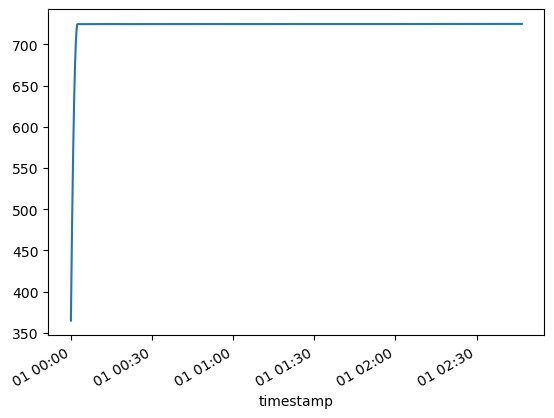

In [107]:
pd.Series(logprc_avg).iloc[:10000].plot()

In [93]:
logprc.resample("1D").transform(lambda x: np.convolve(x, weight_function, "same"))

timestamp
2022-11-01 00:00:00    364.826880
2022-11-01 00:00:01    369.756387
2022-11-01 00:00:02    374.651892
2022-11-01 00:00:03    379.513395
2022-11-01 00:00:04    384.340896
                          ...    
2025-11-30 23:59:55    441.810123
2025-11-30 23:59:56    436.260552
2025-11-30 23:59:57    430.671904
2025-11-30 23:59:58    425.044178
2025-11-30 23:59:59    419.377374
Name: close, Length: 97274010, dtype: float64

In [90]:
ybar

timestamp
2022-11-01 00:00:00         NaN
2022-11-01 00:00:01    4.929507
2022-11-01 00:00:02    4.895505
2022-11-01 00:00:03    4.861503
2022-11-01 00:00:04    4.827501
                         ...   
2025-11-30 23:59:55   -5.510492
2025-11-30 23:59:56   -5.549571
2025-11-30 23:59:57   -5.588649
2025-11-30 23:59:58   -5.627726
2025-11-30 23:59:59   -5.666804
Name: close, Length: 97274010, dtype: float64

In [83]:
(ybar.pow(2)).resample("1D").mean() * 12

timestamp
2022-11-01    0.329830
2022-11-02    0.329145
2022-11-03    0.328659
2022-11-04    0.330470
2022-11-05    0.332295
                ...   
2025-11-26    0.434412
2025-11-27    0.436038
2025-11-28    0.436198
2025-11-29    0.436036
2025-11-30    0.435812
Freq: D, Name: close, Length: 1126, dtype: float64

In [80]:
eta_hat

timestamp
2022-11-01    1.865963e-09
2022-11-02    4.745857e-09
2022-11-03    1.790663e-09
2022-11-04    3.852305e-09
2022-11-05    1.396416e-09
                  ...     
2025-11-26    2.201078e-09
2025-11-27    1.315854e-09
2025-11-28    1.925955e-09
2025-11-29    5.752420e-10
2025-11-30    6.861159e-10
Freq: D, Name: close, Length: 1126, dtype: float64

In [77]:
(ybar.pow(2)).resample("1D").mean() 

timestamp
2022-11-01    0.027486
2022-11-02    0.027429
2022-11-03    0.027388
2022-11-04    0.027539
2022-11-05    0.027691
                ...   
2025-11-26    0.036201
2025-11-27    0.036336
2025-11-28    0.036350
2025-11-29    0.036336
2025-11-30    0.036318
Freq: D, Name: close, Length: 1126, dtype: float64

In [75]:
((ybar.pow(2)).resample("1D").mean() - zeta * eta_hat)

timestamp
2022-11-01    0.027486
2022-11-02    0.027429
2022-11-03    0.027388
2022-11-04    0.027539
2022-11-05    0.027691
                ...   
2025-11-26    0.036201
2025-11-27    0.036336
2025-11-28    0.036350
2025-11-29    0.036336
2025-11-30    0.036318
Freq: D, Name: close, Length: 1126, dtype: float64

In [71]:

weight_function = np.minimum(np.linspace(0,1,K),np.linspace(1,0,K))
zeta = np.square(np.diff(weight_function)).sum()*K
zeta

np.float64(1.0034246575342465)

In [65]:
(ybar.pow(2)).resample("1D").mean()

timestamp
2022-11-01    0.000005
2022-11-02    0.000005
2022-11-03    0.000005
2022-11-04    0.000005
2022-11-05    0.000005
                ...   
2025-11-26    0.000007
2025-11-27    0.000007
2025-11-28    0.000007
2025-11-29    0.000007
2025-11-30    0.000007
Freq: D, Name: close, Length: 1126, dtype: float64

In [64]:
# np.square(np.diff(weight_function)).sum()
zeta # e-7
# * 
# eta_hat # e-9

np.float64(6.382662645801955e-07)

In [54]:
(ybar.pow(2)).resample("1D").mean() 

timestamp
2022-11-01    0.000005
2022-11-02    0.000005
2022-11-03    0.000005
2022-11-04    0.000005
2022-11-05    0.000005
                ...   
2025-11-26    0.000007
2025-11-27    0.000007
2025-11-28    0.000007
2025-11-29    0.000007
2025-11-30    0.000007
Freq: D, Name: close, Length: 1126, dtype: float64

In [30]:
ybar.pow(2)

timestamp
2022-11-01 00:00:00          NaN
2022-11-01 00:00:01    24.300043
2022-11-01 00:00:02    23.965967
2022-11-01 00:00:03    23.634208
2022-11-01 00:00:04    23.304769
                         ...    
2025-11-30 23:59:55    30.365520
2025-11-30 23:59:56    30.797736
2025-11-30 23:59:57    31.232992
2025-11-30 23:59:58    31.671302
2025-11-30 23:59:59    32.112666
Name: close, Length: 97274010, dtype: float64

In [260]:
# rv_arr = xi_sq[:500]
# rv_arr = {torch: torch.Tensor(rv_arr), np:xi_sq[:500]}
# # backend = np

# backend = torch
# torch.
# historical_est, next_est = vol_est_arr(rv_arr[backend], 1,1,0.1, backend=backend)
# likelihood(historical_est, rv_arr[backend], backend=backend)
optimize_torch(df)

/tmp/nix-shell-8343-0/ipykernel_10081/1900012089.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vol_coef, rv_coef, resid = [torch.tensor(x, requires_grad=True) for x in init_params]


loss:-2881.8232421875, params:(0.0, 0.0, 0.0006154610309749842), est:0.0006154610309749842
loss:-2715.57373046875, params:(0.0009999999310821295, 0.0009999999310821295, 0.0016154609620571136), est:0.0016178704099729657
loss:-2848.06201171875, params:(0.00028203317197039723, 0.0017147184116765857, 0.0009356159716844559), est:0.0009372378117404878
loss:-1613.3609619140625, params:(-0.00051025056745857, 0.0024403883144259453, 0.00011541589628905058), est:0.00011728840036084875
loss:-2883.3291015625, params:(-4.4968590373173356e-05, 0.0030474932864308357, 0.0006865235045552254), est:0.0006889053038321435
loss:-2804.32275390625, params:(0.0003355624503456056, 0.003575962968170643, 0.0011669783852994442), est:0.0011702020419761539
loss:-2723.65234375, params:(0.0006036855047568679, 0.004035172052681446, 0.0015750848688185215), est:0.0015792325139045715
loss:-2659.27490234375, params:(0.0007635115180164576, 0.004437504801899195, 0.0019259259570389986), est:0.001930912840180099
loss:-2608.1342

KeyboardInterrupt: 

In [ ]:
torch.array([1,2,3])

AttributeError: module 'torch' has no attribute 'array'

In [ ]:
df2["timestamp"] = pd.to_
1764547195000000	
1500000000000000

,timestamp,close
0,1667260800000,20491.94
1,1667260801000,20491.99
2,1667260802000,20491.62
3,1667260803000,20491.45
4,1667260804000,20491.00
...,...,...
97274005,1764547195000000,90377.40
97274006,1764547196000000,90360.01
97274007,1764547197000000,90360.00
97274008,1764547198000000,90360.01


In [ ]:
pd.to_datetime(df.iloc[-10:][f].apply(lambda x: (x*1000000) if x<1500000000000000 else (x*1000)))

2591990   2025-11-30 23:59:50
2591991   2025-11-30 23:59:51
2591992   2025-11-30 23:59:52
2591993   2025-11-30 23:59:53
2591994   2025-11-30 23:59:54
2591995   2025-11-30 23:59:55
2591996   2025-11-30 23:59:56
2591997   2025-11-30 23:59:57
2591998   2025-11-30 23:59:58
2591999   2025-11-30 23:59:59
Name: timestamp, dtype: datetime64[ns]

In [ ]:
pd.to_datetime(df[f].apply(lambda x: (x*1000) if x<1500000000000000 else x))


KeyboardInterrupt: 

In [ ]:
f = "timestamp"

In [ ]:
df[f]

In [ ]:
df["close"]#.resample("1D").last().plot()

timestamp
1970-01-20 07:50:52.800    17164.00
1970-01-20 07:50:52.801    17166.48
1970-01-20 07:50:52.802    17165.76
1970-01-20 07:50:52.803    17164.07
1970-01-20 07:50:52.804    17164.12
                             ...   
1970-01-21 10:09:07.195    90377.40
1970-01-21 10:09:07.196    90360.01
1970-01-21 10:09:07.197    90360.00
1970-01-21 10:09:07.198    90360.01
1970-01-21 10:09:07.199    90360.00
Name: close, Length: 94683723, dtype: float64

In [ ]:
df.apply(lambda x: x, inplace=True)

TypeError: <lambda>() got an unexpected keyword argument 'inplace'

In [ ]:
# a = pd.read_csv("./data/BTCUSDT-1s-"+"2025-11"+".zip", header=None, index_col=0, names=names)
pd.to_datetime(a.index*1000)

DatetimeIndex(['2025-11-01 00:00:00', '2025-11-01 00:00:01',
               '2025-11-01 00:00:02', '2025-11-01 00:00:03',
               '2025-11-01 00:00:04', '2025-11-01 00:00:05',
               '2025-11-01 00:00:06', '2025-11-01 00:00:07',
               '2025-11-01 00:00:08', '2025-11-01 00:00:09',
               ...
               '2025-11-30 23:59:50', '2025-11-30 23:59:51',
               '2025-11-30 23:59:52', '2025-11-30 23:59:53',
               '2025-11-30 23:59:54', '2025-11-30 23:59:55',
               '2025-11-30 23:59:56', '2025-11-30 23:59:57',
               '2025-11-30 23:59:58', '2025-11-30 23:59:59'],
              dtype='datetime64[ns]', name='timestamp', length=2592000, freq=None)

In [ ]:
df.index[::24*60*60*21]

Index([   1698796800000,    1700611200000,    1702425600000,    1704240000000,
          1706054400000,    1707868800000,    1709683200000,    1711497600000,
          1713312000000,    1715126400000,    1716940800000,    1718755200000,
          1720569600000,    1722384000000,    1724198400000,    1726012800000,
          1727827200000,    1729641600000,    1731456000000,    1733270400000,
          1735084800000, 1736899200000000, 1738713600000000, 1740528000000000,
       1742342400000000, 1744156800000000, 1745971200000000, 1747785600000000,
       1749600000000000, 1751414400000000, 1753228800000000, 1755043200000000,
       1756857600000000, 1758672000000000, 1760486400000000, 1762300800000000,
       1764115200000000],
      dtype='int64', name='timestamp')

In [ ]:
# df["close"].diff()
df.index

Index([   1698796800000,    1698796801000,    1698796802000,    1698796803000,
          1698796804000,    1698796805000,    1698796806000,    1698796807000,
          1698796808000,    1698796809000,
       ...
       1764547190000000, 1764547191000000, 1764547192000000, 1764547193000000,
       1764547194000000, 1764547195000000, 1764547196000000, 1764547197000000,
       1764547198000000, 1764547199000000],
      dtype='int64', name='timestamp', length=65750400)

In [ ]:
GARCH(1,1)
Unified GARCH-Itô(1,1)
Realized GARCH-Itô(1,1)

,open,high,low,close,volume_BTC,close time,volume_USDT,num_trade,sell_volume_in_BTC,buy_volume_in_USDT,_
timestamp,,,,,,,,,,,
1698796800000,34639.78,34639.78,34639.77,34639.77,0.06905,1698796800999,2391.876513,28,0.03947,1367.232117,0
1698796801000,34639.77,34639.78,34639.77,34639.77,0.15223,1698796801999,5273.212560,13,0.03728,1291.370998,0
1698796802000,34639.78,34639.78,34639.78,34639.78,0.00426,1698796802999,147.565463,5,0.00426,147.565463,0
1698796803000,34639.78,34639.78,34639.77,34639.77,0.13590,1698796803999,4707.544896,7,0.01528,529.295838,0
1698796804000,34639.78,34639.78,34639.77,34639.77,0.14178,1698796804999,4911.227267,7,0.06765,2343.381117,0
...,...,...,...,...,...,...,...,...,...,...,...
1764547195000000,90377.40,90377.40,90377.40,90377.40,0.00000,1764547195999999,0.000000,0,0.00000,0.000000,0
1764547196000000,90377.40,90377.40,90360.01,90360.01,0.32662,1764547196999999,29517.096334,223,0.00900,813.244878,0
1764547197000000,90360.00,90360.00,90360.00,90360.00,0.00048,1764547197999999,43.372800,2,0.00000,0.000000,0
